In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv src/.env

%matplotlib inline

In [2]:
import os
os.chdir('/Users/kushagrasharma/coding/hormozlab/src')

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors

import torch

In [4]:
from utils import gaussian_centered_on_vertex

In [5]:
DATA_DIR = os.environ.get("DATA_DIR")
MODELS_DIR = os.environ.get("MODELS_DIR")
EPSILON_N_P_I = float(os.environ.get("EPSILON_N_P_I"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_full = pd.read_csv(DATA_DIR + 'scvi_train_set_gapdh.csv', header=None).to_numpy()
train_umap = pd.read_csv(DATA_DIR + 'train_coords.csv', header=None).to_numpy()

## Systematically Choosing $\sigma$ for our Gaussian Distribution in Transcriptome Space
The target of our reconstruction is a function over transcriptome space. In particular, we aim to reconstruct a Gaussian distribution centered on the target cell. The "ground truth" distribution centered on the $j$th cell is thus $p(i)\propto \exp(-(\frac{\lVert x^{(j)} - x^{(i)} \rVert}{\sigma})^2)$ for the $i$th cell. Note that the distance measure is the squared $L^2$ norm in transcriptome space. 

This begs the question of how to select the standard deviation, $\sigma$. The purpose of using a Gaussian distribution as opposed to, say, an indicator function is to provide some degree of smoothness around our target cell, but the aim is still for our reconstruction to be highly similar to our target cell. In other words, we want some small number of cells around the target cell to be in our ground truth distribution. To select $\sigma$, we chose $N=10$ as the number of cells, not including the target cell, to include in our ground truth distribution. 

One way we could systematically choose $\sigma$ could be the following method. For a given distribution $p(i)$, we define the number of cells included in the distribution as $N(p(i))=|\{i\}|$ for $i$ such that $p(i)$ is nonnegligible, i.e. $p(i)\geq \epsilon$ for $\epsilon=5\times 10^{-3}$. We could then choose the minimum value of $\sigma$ such that $N(p(i))\geq 10$. 

The value of $\sigma$ that will give us the desired number of proximal cells in the ground truth distribution will vary by cell, since the local distributions of cells in transcriptome space varies, both in our dataset and biologically. Thus, we wanted to investigate the degree of variance in this respect for our dataset. We begin by considering the distribution of $N(p(i))$ for $\sigma=5$ over the cells in our training set.  

In [7]:
gaussian_train_sigma_5 = np.load(DATA_DIR + 'precomputed_gaussian_sigma_5.npy')

In [8]:
N_p_i = lambda x: (x > EPSILON_N_P_I).sum()

N_gaussian_5 = np.apply_along_axis(N_p_i, 1, gaussian_train_sigma_5)

Text(0.5, 1.0, 'Distribution over $N(p(i))$ for $\\sigma=5$')

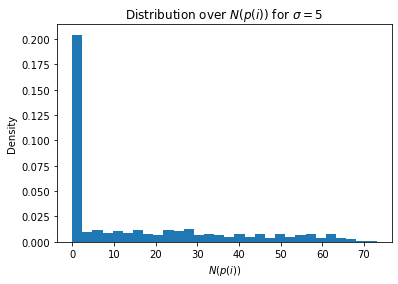

In [9]:
plt.hist(N_gaussian_5, density=True, bins=30, stacked=True)  # density=False would make counts
plt.ylabel(r'Density')
plt.xlabel(r'$N(p(i))$');
plt.title(r'Distribution over $N(p(i))$ for $\sigma=5$')

The above results indicate that there are a large number of cells that require a significantly larger value of $\sigma$ to have an acceptable $N(p(i))$. There is a large amount of variance in $N(p(i))$ in general for $\sigma=5$. This indicates to us that we'll need to choose custom values of $\sigma$ for each cell that meet our desired criteria. 

One way we could do this could be, as previously mentioned, to run a binary search for the minimum value of $\sigma$ such that our criteria, $N(p(i))\geq 10$, is met. Unfortunately, $N(p(i))$ is not monotonic in $\sigma$. We can see this by noting that for $\sigma\rightarrow \infty$, we get a uniform distribution, with all probabilities lower than our threshold, and $N(p(i))=0$. This can also be seen in the below graph of the distribution of $N(p(i))$ with $\sigma=100$. 

In [10]:
gaussian_sigma_100 = gaussian_train_sigma_5 = np.load(DATA_DIR + 'precomputed_gaussian_sigma_100.npy')

N_gaussian_100 = np.apply_along_axis(N_p_i, 1, gaussian_sigma_100)

Text(0.5, 1.0, 'Distribution over $N(p(i))$ for $\\sigma=100$')

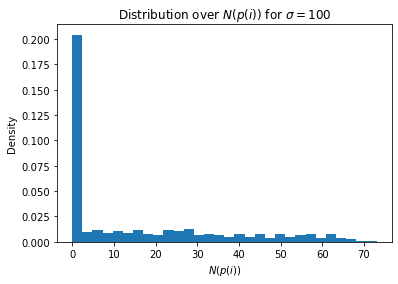

In [11]:
plt.hist(N_gaussian_100, density=True, bins=30, stacked=True)  # density=False would make counts
plt.ylabel(r'Density')
plt.xlabel(r'$N(p(i))$');
plt.title(r'Distribution over $N(p(i))$ for $\sigma=100$')

Thus, $N(p(i))$ is not an appropriate metric to search over. One could alternatively search using a function that is monotonic in $\sigma$, for example, the entropy, or the number of cells inside the $2\sigma$ interval. We instead choose an elegant exact method, which is setting $\sigma_j=\lVert x^{(j)}-x^{(j)}_{10}\rVert$ where $x^{(j)}_{10}$ is the $10$th nearest neighbor to $x^{(j)}$. This functionally creates a distribution with 10 cells in the $\approx 95\%$ interval from the mean.

We now set $\sigma_j$ to the above value. To ensure that this setting gives us the desired results, we plot the distribution of the number of cells in the $95\%$ interval, the distribution of the entropy for each distribution, and for the sake of consistency with our previous metric, the distribution of $N(p(i))$. 

In [12]:
gaussian_sigma_2sd = np.load(DATA_DIR + 'precomputed_gaussian_sigma_10thNN.npy')

In [13]:
def n_cells_in_density(distribution, density):
    n_cells = 0
    distribution = -np.sort(-distribution)
    cum_density = 0
    for p in distribution:
        cum_density += p
        n_cells += 1
        if cum_density >= density:
            return n_cells
    return n_cells

Text(0.5, 1.0, 'Distribution over Number of Cells in $95\\%$ Interval for Systematic $\\sigma$')

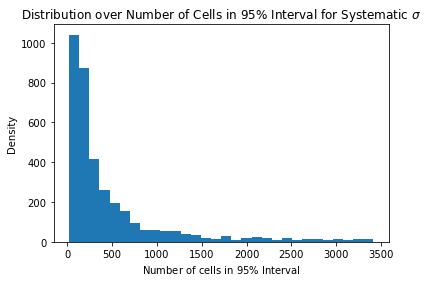

In [14]:
n_cells_95_interval = np.apply_along_axis(lambda x: n_cells_in_density(x, .95), 1, gaussian_sigma_2sd)

plt.hist(n_cells_95_interval, density=False, bins=30)  # density=False would make counts
plt.ylabel(r'Density')
plt.xlabel(r'Number of cells in $95\%$ Interval');
plt.title(r'Distribution over Number of Cells in $95\%$ Interval for Systematic $\sigma$')

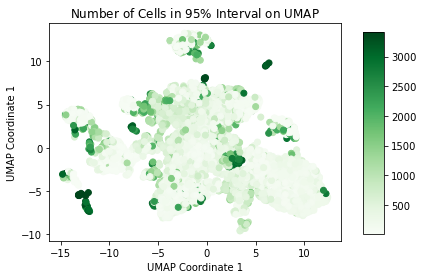

In [34]:
im = plt.scatter(train_umap[:,0], train_umap[:,1], c=n_cells_95_interval, cmap='Greens')
plt.title(r'Number of Cells in $95\%$ Interval on UMAP')
plt.xlabel("UMAP Coordinate 1")
plt.ylabel("UMAP Coordinate 1")
plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)

We can overlay this histogram of the number of cells in the $95\%$ interval onto the UMAP plot to visualize how this distribution is arranged spatially. 

Text(0.5, 1.0, 'Distribution over $N(p(i))$ for Systematic $\\sigma$')

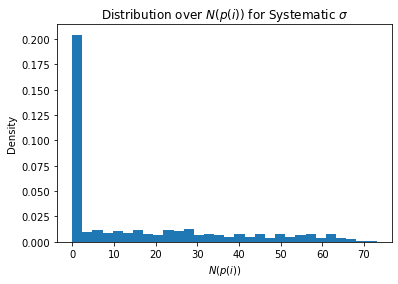

In [16]:
N_gaussian_sigma_2sd = np.apply_along_axis(N_p_i, 1, gaussian_sigma_2sd)
plt.hist(N_gaussian_5, density=True, bins=30, stacked=True)  # density=False would make counts
plt.ylabel(r'Density')
plt.xlabel(r'$N(p(i))$');
plt.title(r'Distribution over $N(p(i))$ for Systematic $\sigma$')

Text(0.5, 1.0, 'Distribution over Entropy for Ground Truth Distribution with Systematic $\\sigma$')

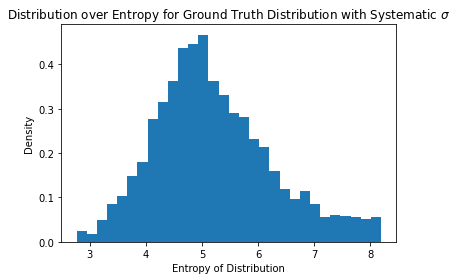

In [17]:
n_cells_95_entropy = np.apply_along_axis(entropy, 1, gaussian_sigma_2sd)

plt.hist(n_cells_95_entropy, density=True, bins=30, stacked=True)  # density=False would make counts
plt.ylabel(r'Density')
plt.xlabel(r'Entropy of Distribution');
plt.title(r'Distribution over Entropy for Ground Truth Distribution with Systematic $\sigma$')

Unfortunately, as can be seen in the first figure, there is still more variance in the number of cells with non-negligible ground truth distribution probabilites that we'd like. We can examine why this is the case by looking in more detail at, for example, the cell at the rightmost end of the distribution, with $N=3415$ cells included in its $95\%$ confidence interval. We can first examine the summary statistics of the distribution.

In [18]:
max_idx = n_cells_95_interval.argmax()

In [19]:
pd.DataFrame(gaussian_sigma_2sd[max_idx]).describe()

,0
count,3595.000000
mean,0.000278
std,0.000011
min,0.000267
25%,0.000277
50%,0.000277
75%,0.000277
max,0.000785


It appears that we have a highly uniform distribution. To understand why, we look at the distances of the $10$ nearest neighbors to the outlier cell relative to the median cell with respect to the confidence interval distribution, which will give us insight into $\sigma$ for the underlying distribution. 

In [20]:
neigh = NearestNeighbors(n_neighbors=10, n_jobs=-1)
neigh.fit(train_full)
neighbors = neigh.kneighbors(train_full, return_distance=True)

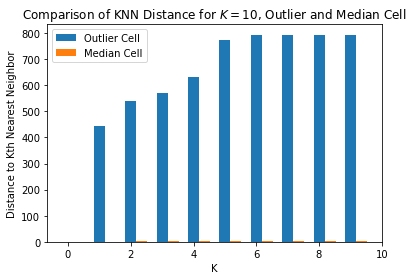

In [21]:
med_idx = n_cells_95_interval[np.percentile(n_cells_95_interval,50,interpolation='nearest')]
ind = np.arange(len(neighbors[0][max_idx])) 
width = 0.35
plt.bar(ind, neighbors[0][max_idx], width, label='Outlier Cell')
plt.bar(ind + width, neighbors[0][med_idx], width,
    label='Median Cell')

plt.ylabel('Distance to Kth Nearest Neighbor')
plt.title('Comparison of KNN Distance for $K=10$, Outlier and Median Cell')

plt.xlabel("K")
plt.legend(loc='best')

As we can see, there's huge variance in distance to the $10$th nearest neighbor (and nearest neighbors in general), with our outlier cell being very far away from all cells. Note that even the median cell plotted here has $\approx N=200$ cells in its $95\%$ confidence interval. Thus, our solution is to truncate the distribution for each cell at the $11$ highest probability cells ($10$ plus the true cell), appropriately normalized. 

In [22]:
truncated_idxs = np.argsort(-gaussian_sigma_2sd, axis=1)[:,11:]
truncated_gaussian = np.copy(gaussian_sigma_2sd)

In [23]:
for i in range(len(gaussian_sigma_2sd)):
    truncated_gaussian[i,:][truncated_idxs[i,:]] = 0 
    truncated_gaussian[i,:] /= truncated_gaussian[i,:].sum()
    
np.save(DATA_DIR + 'truncated_gaussian_sigma_10thNN.npy', truncated_gaussian)

We can now visualize the resulting distributions by plotting probabilities on a UMAP visualzation for a few cells. Below we examine the outlier cell, the median cell, and two randomly selected cells. 

Text(0.5, 1.0, 'Gaussian on UMAP Cells for Outlier Cell')

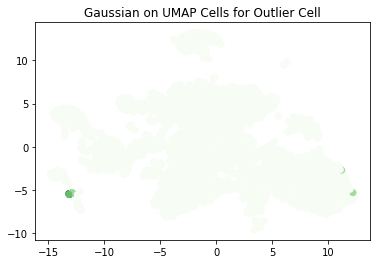

In [24]:
plt.scatter(train_umap[:,0], train_umap[:,1], c=truncated_gaussian[max_idx,:], cmap='Greens')
plt.title(r'Gaussian on UMAP Cells for Outlier Cell')

Text(0.5, 1.0, 'Gaussian on UMAP Cells for Median Cell')

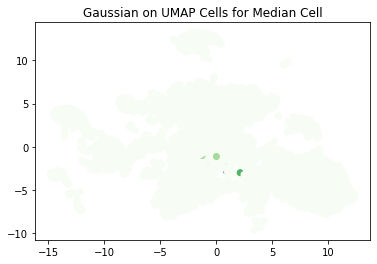

In [25]:
plt.scatter(train_umap[:,0], train_umap[:,1], c=truncated_gaussian[med_idx,:], cmap='Greens')
plt.title(r'Gaussian on UMAP Cells for Median Cell')

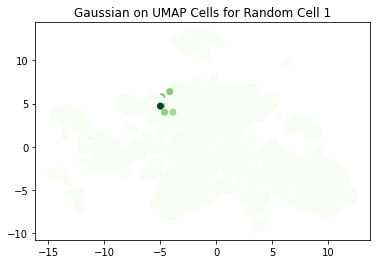

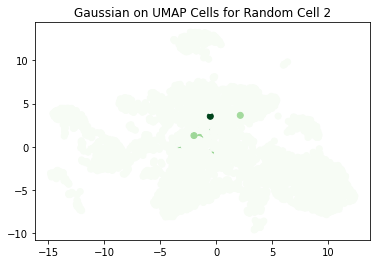

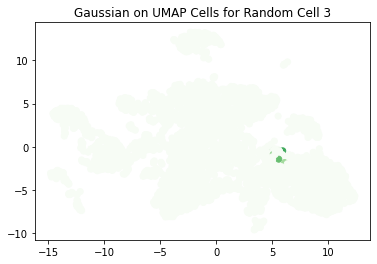

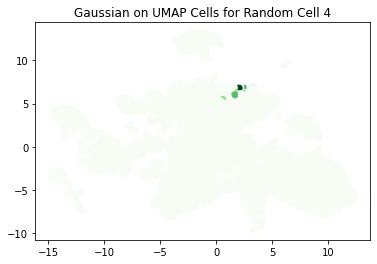

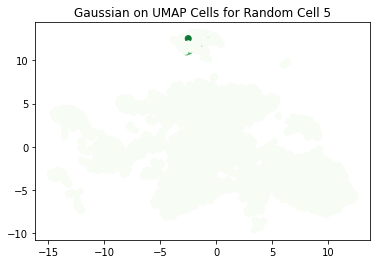

In [26]:
for i in range(5):
    plt.scatter(train_umap[:,0], train_umap[:,1], c=truncated_gaussian[np.random.randint(0, len(train_full)),:], cmap='Greens')
    plt.title(r'Gaussian on UMAP Cells for Random Cell {}'.format(i+1))
    plt.show()

As we can see, the resulting distributions are not perfect but are decently localized and peaked on the target cell. Note that UMAP visualizations themselves make assumptions about cell-cell distances and thus distance on a UMAP plot is not necessarily equivalent to biologically-relevant distance in transcriptome space. We can see this by plotting key marker genes and seeing non-perfect localization, as is done in our section on choosing $K$ for our $K$NNG.

Finally, we plot a few distributions for randomly selected cells so we can get a sense of the shape. 

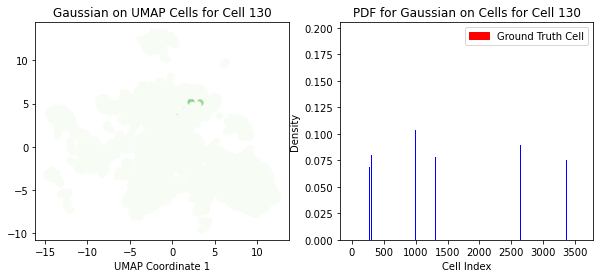

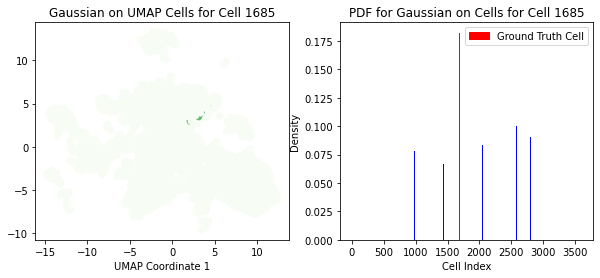

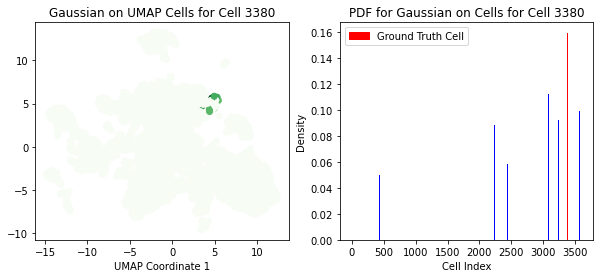

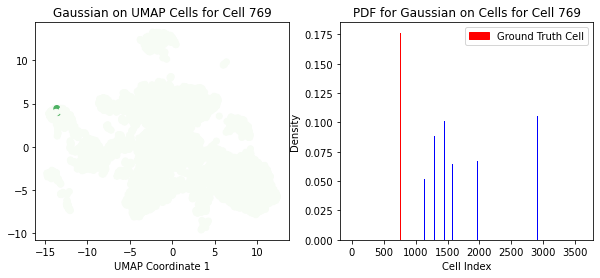

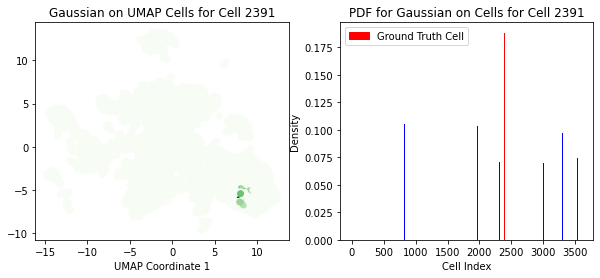

In [39]:
for i in range(5):
    idx = np.random.randint(0, len(train_full))
    colors = ['b'] * len(train_umap)
    colors[idx] = 'r'
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.scatter(train_umap[:,0], train_umap[:,1], c=truncated_gaussian[idx,:], cmap='Greens')
    ax1.set_title(r'Gaussian on UMAP Cells for Cell {}'.format(idx))
    ax1.set_xlabel("UMAP Coordinate 1")
    ax2.set_ylabel("UMAP Coordinate 2")
    ax2.bar(np.arange(len(truncated_gaussian)), 
            truncated_gaussian[idx,:], width=10, color=colors)
    ax2.set_title("PDF for Gaussian on Cells for Cell {}".format(idx))
    ax2.set_xlabel("Cell Index")
    ax2.set_ylabel("Density")
    red_patch = mpatches.Patch(color='red', label='Ground Truth Cell')
    ax2.legend(handles=[red_patch])
    plt.show()